# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires the DSS version of Vensim
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.1.1](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, MultiprocessingEvaluator, SequentialEvaluator

from ema_workbench.analysis.plotting import lines, Density


def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

C:\Programs\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Programs\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Programs\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Programs\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Python Model

In [2]:
ema_logging.LOG_FORMAT = '[%(name)s/%(levelname)s/%(processName)s] %(message)s'
ema_logging.log_to_stderr(ema_logging.INFO)

python_model = Model('PythonPredPrey', function=PredPrey)  # instantiate the model

# specify uncertainties
python_model.uncertainties = [RealParameter("prey_birth_rate", 0.015, 0.035),
                              RealParameter("predation_rate", 0.0005, 0.003),
                              RealParameter("predator_efficiency", 0.001, 0.004),
                              RealParameter("predator_loss_rate", 0.04, 0.08)]
# specify outcomes
python_model.outcomes = [TimeSeriesOutcome('predators', function=np.squeeze),
                         TimeSeriesOutcome('prey', function=np.squeeze)]

python_results = perform_experiments(python_model, 50)

[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing experiments sequentially
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 5 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 10 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 15 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 20 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 25 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 30 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 35 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 40 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 45 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 50 ca

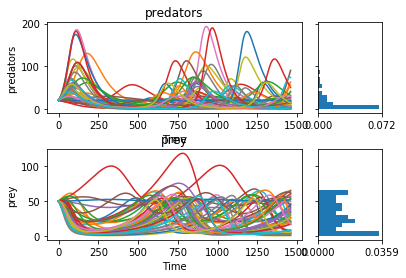

In [3]:
python_experiments, python_outcomes = python_results
lines(python_experiments, python_outcomes, density=Density.HIST)
plt.show()

To calculate the absolute error, we have chosen to consider the default values in the python model as a 'baseline'. The result below shows a maximum error that is close to the peak height. This means that the maximum error possible is the difference between a peak and a valley at a given time, meaning the model and parameters chosen are very significant when predicting the size of the population.

In [4]:
python_baseline = PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1)

df_python_prey_baseline = pd.DataFrame(python_baseline["prey"]).T 

df_python_prey = pd.DataFrame(python_outcomes["prey"]).T 

pdf_subtract = df_python_prey.sub(df_python_prey_baseline[0], axis=0)
python_error=pdf_subtract.abs().max().max()

print("The maximum error between the baseline model and the python scenario model is %.2f" % python_error)

The maximum error between the baseline model and the python scenario model is 89.78


The two graphs above (from the Python implementation) show the development of predators and preys over time. The aim of this modelling is to show the dynamics between predators and prey. Each time the model is run, the outcome looks slightly different, as the scenarios are based on change. However, there are still a few general conclusions that can be taken from the model. Firstly, one can observe the dynamic relationship between predators and prey. The functions for both reach similar peaks, but the prey peaks have a short time lag. Thinking about ecosystem dynamicys, this is a logical conclusion. Secondly, it can be observed that for most model runs, the majority of scenarios lie between 0 and 100 for predators and between 0 and 50 for prey. Only a few "outliers" usually lie above it (though there might be a few model runs were this might look different). The patterns are also repeating suggesting a steady state result for each particular set of parameters.

## Vensim Model

In [5]:
vensim_model = PysdModel("VensimPredPrey", mdl_file="./model/PredPrey.mdl")

vensim_model.uncertainties = [RealParameter("prey_birth_rate", 0.015, 0.035),
                              RealParameter("predation_rate", 0.0005, 0.003),
                              RealParameter("predator_efficiency", 0.001, 0.004),
                              RealParameter("predator_loss_rate", 0.04, 0.08)]

vensim_model.outcomes = [TimeSeriesOutcome('predators'),
                         TimeSeriesOutcome('prey')]
vensim_results = perform_experiments(vensim_model, 50)

[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing experiments sequentially
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 5 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 10 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 15 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 20 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 25 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 30 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 35 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 40 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 45 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 50 ca

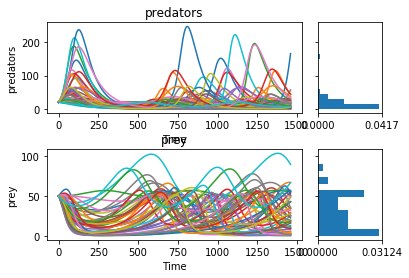

In [6]:
vensim_experiments, vensim_outcomes = vensim_results
lines(vensim_experiments, vensim_outcomes, density=Density.HIST)
plt.show()

In [7]:
df_vensim_prey = pd.DataFrame(vensim_outcomes["prey"]).T 

df_vensim_subtract = df_vensim_prey.sub(df_python_prey_baseline[0], axis=0)
vensim_error=df_vensim_subtract.abs().max().max()

print("The maximum error between the baseline model and the python scenario model is %.2f" % vensim_error)

The maximum error between the baseline model and the python scenario model is 69.24


The graphs shown appear similar in nature compared to the python model. The exact results differ, because the chosen parameters are different. It's clearly visible the predator peaks follow the prey peaks, and the prey minima follow predator peaks. The maximum error is again large, which is nearly the difference between the maximum and minimum.

## Excel Model

In [8]:
excel_model = ExcelModel("ExcelPredatorPrey", wd="./model",
                       model_file='PredPrey.xlsx')
excel_model.uncertainties = [RealParameter("prey_birth_rate", 0.015, 0.035),
                             RealParameter("predation_rate", 0.0005, 0.003),
                             RealParameter("predator_efficiency", 0.001, 0.004),
                             RealParameter("predator_loss_rate", 0.04, 0.08)]

    # specification of the outcomes
excel_model.outcomes = [TimeSeriesOutcome('B18:BDF18', function=np.squeeze),
                        TimeSeriesOutcome('B17:BDF17', function=np.squeeze)]  # we can also use named range

    # name of the sheet
excel_model.default_sheet = "Sheet1"

excel_results = perform_experiments(excel_model, 50, reporting_interval=10)

[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing experiments sequentially
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 10 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 20 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 30 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 40 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 50 cases completed
[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] experiments finished


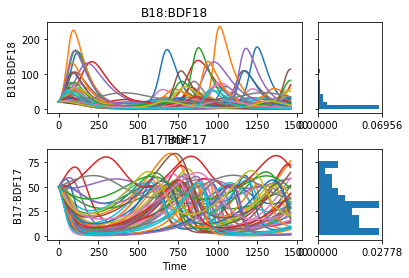

In [9]:
excel_experiments, excel_outcomes = excel_results
lines(excel_experiments, excel_outcomes, density=Density.HIST)
plt.show()

In [10]:
df_excel_prey = pd.DataFrame(excel_outcomes["B17:BDF17"]).T 

df_excel_subtract = df_excel_prey.sub(df_python_prey_baseline[0], axis=0)
excel_error=df_excel_subtract.abs().max().max()

print("The maximum error between the baseline model and the python scenario model is %.2f" % excel_error)

The maximum error between the baseline model and the python scenario model is 63.88


This model shows similar results and error to the python and vensim model, but exact outcomes are highly dependent on the particular parameters. Therefore, it seems 50 experiments for this case seems a bit low to provide meaningful patterns.

## NetLogo Model

Unfortunately, we could not get this model to run properly due to a java home error, but the implementation is be shown below:

In [11]:
netlogo_model = NetLogoModel("NetlogoPredatorPrey", wd="./model",
                       model_file='PredPrey.nlogo')

netlogo_model.uncertainties = [RealParameter("prey_birth_rate", 0.015, 0.035),
                               RealParameter("predation_rate", 0.0005, 0.03),
                               RealParameter("predator_efficiency", 0.001, 0.004),
                               RealParameter("predator_loss_rate", 0.04, 0.08)]

    # specification of the outcomes
netlogo_model.outcomes = [TimeSeriesOutcome("prey"),  # we can refer to a range in the normal way
                          TimeSeriesOutcome("predators")]  # we can also use named range

netlogo_results = perform_experiments(netlogo_model, 50, reporting_interval=10)

[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing experiments sequentially
[EMA.ema_workbench.em_framework.experiment_runner/ERROR/MainProcess] No JVM shared library file (jvm.dll) found. Try setting up the JAVA_HOME environment variable properly.
Traceback (most recent call last):
  File "C:\Programs\Anaconda3\lib\site-packages\ema_workbench\em_framework\experiment_runner.py", line 85, in run_experiment
    model.run_model(scenario, policy)
  File "C:\Programs\Anaconda3\lib\site-packages\ema_workbench\util\ema_logging.py", line 158, in wrapper
    res = func(*args, **kwargs)
  File "C:\Programs\Anaconda3\lib\site-packages\ema_workbench\em_framework\model.py", line 296, in run_model
    super(Replicator, self).run_model(scenario, policy)
  File "C:\Programs\Anaconda3\lib\site-packages\ema_workbench\util\ema_logging.py", line 158, in wrapp

JVMNotFoundException: No JVM shared library file (jvm.dll) found. Try setting up the JAVA_HOME environment variable properly.